In [15]:
__author__ = 'mlorenzi'

import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.integrate import odeint
np.random.seed(10)
random.seed(10)

class DataGenerator(object):
    def __init__(self, Nbiom, interval, param, propagation_model = 'monotonic'):
        self.propagation_model = propagation_model
        self.Nbiom = Nbiom
        self.model = []
        self.interval = interval # interval is list[start, stop]
        self.param = param
        self.shiftData = []

        for i in range(Nbiom):
            shift = np.random.randint(interval[0], interval[1]) # shift is a random int within interval
            if propagation_model == 'ACP':
                self.shiftData.append([shift + l for l in range(int(interval[0]), int(interval[1]))])
                self.model.append(generate_data_ACP(len(self.shiftData[i]), param[-2], param, self.shiftData[i][0],self.shiftData[i][-1])[1][:, i])
            elif propagation_model == 'diffusion':
                self.shiftData.append([shift + l for l in range(int(interval[0]), int(interval[1]))])
                self.model.append(generate_data_diffusion(len(self.shiftData[i]), param[-2], param,
                                                          self.shiftData[i][0], self.shiftData[i][-1])[1][:, i])
            elif propagation_model == 'reaction-diffusion':
                self.shiftData.append([shift + l for l in range(int(interval[0]), int(interval[1]))])
                self.model.append(generate_data_reactiondiffusion(len(self.shiftData[i]), param[-2], param,
                                                                       self.shiftData[i][0],self.shiftData[i][-1])[1][:, i])
            else:
                self.shiftData.append([shift + l for l in range(int(float(interval[0])/2), int(float(interval[1])/2))])
                self.model.append(self.f(self.shiftData[i], param[i][0], param[i][1]))

     
        plt.plot(np.array(self.model).T)
        print(np.array(self.model).T.shape)

    def f(self, X, L, k):
        return [L / (1 + np.exp(-k * i)) for i in X]
    
## ACP

def generate_data_ACP(n, x0, param, tmin, tmax):
    def ode_ACP(x, t, theta):
        return np.dot(theta(x), x).tolist()

    kij = param[0][0]
    kt = param[0][1]
    tau1 = param[0][2]
    difftau12 = param[0][3]
    tau2 = tau1 + difftau12
    l1 = param[1]
    l2 = param[2]
    A = param[4]

    def M(x):
        kt_matrix = np.full([int(A.shape[0]), int(A.shape[0])], kt) / (1 + np.exp(l2 * (x - tau2)))
        Mac = np.diag(np.diag(np.full((int(A.shape[0]), int(A.shape[0])), kt_matrix)))

        kij_matrix = np.zeros([A.shape[0], A.shape[0]])
        kij_matrix[np.triu_indices(A.shape[0], 1)] = kij.reshape(int((A.shape[0] * A.shape[0] - A.shape[0]) / 2), )
        kij_matrix = (kij_matrix + kij_matrix.T)
        kij_matrix = kij_matrix / ((1 + np.exp(-l1 * (x - tau1))) * (1 + np.exp(l2 * (x - tau2))))

        Min = np.multiply(kij_matrix, A)  # intake
        Mout = np.diag(np.sum(Min, axis=0))  # out-take
        M = Mac + Min - Mout
        return M

    t = np.linspace(tmin, tmax, n)
    y = odeint(ode_ACP, x0.reshape(A.shape[0], ), t, args=(M,))

    return t, y

# DIFF

def generate_data_diffusion(n, x0, param, tmin, tmax):
    def ode_diffusion(x, t, theta):
        return np.dot(theta, x).tolist()

    kij = param[0]
    A = param[4]
    
    kt_matrix = np.full([int(A.shape[0]), int(A.shape[0])], 0.1) # initial trigger of unbalanced accumulation
    Mac = np.diag(np.diag(np.full((int(A.shape[0]), int(A.shape[0])), kt_matrix)))

    kij_matrix = np.zeros([A.shape[0], A.shape[0]])
    kij_matrix[np.triu_indices(A.shape[0], 1)] = kij.reshape(int((A.shape[0] * A.shape[0] - A.shape[0]) / 2), )
    kij_matrix = (kij_matrix + kij_matrix.T)
    Min = np.multiply(kij_matrix, A)  # intake
    Mout = np.diag(np.sum(Min, axis=0))  # out-take
    M0 =  Mac + Min - Mout

    t = np.linspace(tmin, tmax, n)
    y = odeint(ode_diffusion, x0.reshape(A.shape[0], ), t, args=(M0,))

    return t, y

## RD

def generate_data_reactiondiffusion(n, x0, param, tmin, tmax):
    def ode_reactiondiffusion(x, t, theta):
        M0 = theta[0]
        R1 = theta[1]
        R2 = theta[2]
        return (np.dot(M0, x).reshape(len(x),) + (R1*x).reshape(len(x),) - (R2*x**2).reshape(len(x),)).tolist()

    kij = param[0][0]
    kt = param[0][1]
    tau = param[0][2]
    A = param[4]

    ## diffusion

    kt_matrix = np.full([int(A.shape[0]), int(A.shape[0])], .1) # initial trigger of unbalanced accumulation
    Mac = np.diag(np.diag(np.full((int(A.shape[0]), int(A.shape[0])), kt_matrix)))
    kij_matrix = np.zeros([A.shape[0], A.shape[0]])
    kij_matrix[np.triu_indices(A.shape[0], 1)] = kij.reshape(int((A.shape[0] * A.shape[0] - A.shape[0]) / 2), )
    kij_matrix = (kij_matrix + kij_matrix.T)
    Min = np.multiply(kij_matrix, A)  # intake
    Mout = np.diag(np.sum(Min, axis=0))  # out-take
    M0 =  Mac + Min - Mout

    ## reaction
    
    R1 = kt*tau.squeeze()
    R2 = kt

    M = (M0,R1,R2)
    t = np.linspace(tmin, tmax, n)
    y = odeint(ode_reactiondiffusion, x0.reshape(A.shape[0], ), t, args=(M,))

    return t, y

def GenerateConnectome(N):
    matrix = np.random.randint(2, size=(N,N))
    # If i is connected to j, j is connected to i
    matrix = matrix + matrix.T
    matrix = (matrix < 2).astype(int)
    # No vertex connects to itself
    np.fill_diagonal(matrix, 0)

    return matrix

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

(10, 10)


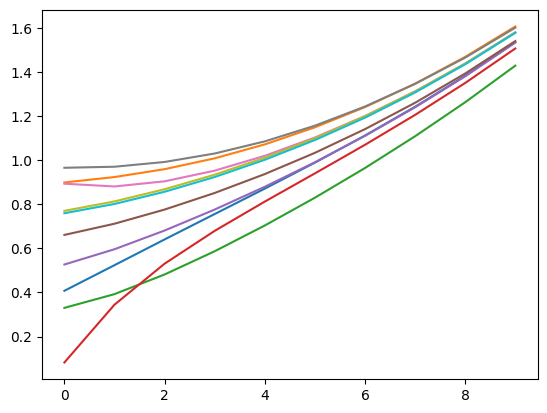

In [16]:
np.random.seed(5)

n_biomarkers = 10
n_connections = int(n_biomarkers * (n_biomarkers - 1) / 2)
kij = np.random.normal(loc=0.05, scale=0.05, size=n_connections)
    
param = []

param.append(kij)
param.append([])
param.append([])
param.append([])

A = GenerateConnectome(n_biomarkers)
param.append(A)
x0 = np.random.random(n_biomarkers)
param[-2] = x0

data_gen = DataGenerator(Nbiom=n_biomarkers, interval=[0, 10], param=param, propagation_model='diffusion')

(10, 10)


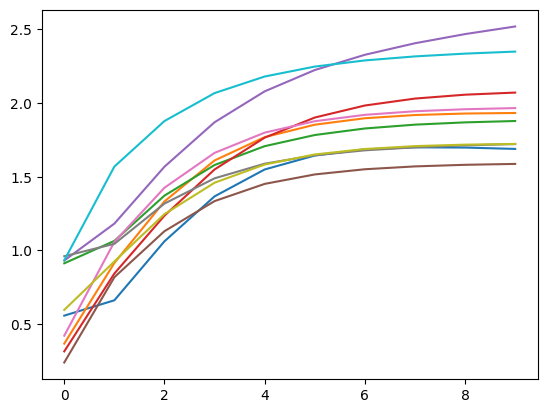

In [5]:
np.random.seed(11)

n_biomarkers = 10
n_connections = int(n_biomarkers * (n_biomarkers - 1) / 2)
kij = np.random.normal(loc=0.5, scale=0.5, size=n_connections)

kt = np.random.normal(loc=0.5, scale=0.5, size=n_biomarkers)
tau = np.random.normal(loc=1.5, scale=0.5, size=n_biomarkers)

param = []
param.append([kij, kt, tau])
param.append([])
param.append([])
param.append([])

A = GenerateConnectome(n_biomarkers)
param.append(A)
x0 = np.random.random(n_biomarkers)
param[-2] = x0

data_gen = DataGenerator(Nbiom= n_biomarkers, interval=[0, 10], param=param, propagation_model='reaction-diffusion')

(10, 10)


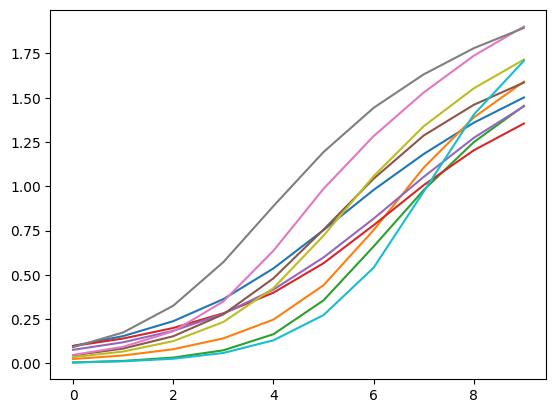

In [6]:
np.random.seed(11)

n_biomarkers = 10
n_connections = int(n_biomarkers * (n_biomarkers - 1) / 2)
kij = np.random.normal(loc=0.05, scale=0.1, size=n_connections)

kt = np.random.normal(loc=0.6, scale=0.1, size=n_biomarkers)
tau = np.random.normal(loc=0.9, scale=0.1, size=n_biomarkers)
difftau = np.random.normal(loc=0.1, scale=0.1, size=n_biomarkers)

l1 = np.random.normal(loc=3, scale=0.1, size=n_biomarkers)
l2 = np.random.normal(loc=3, scale=0.1, size=n_biomarkers)
param = []
param.append([kij, kt, tau, difftau])
param.append(l1)
param.append(l2)
param.append([])

A = GenerateConnectome(n_biomarkers)
param.append(A)
x0 = np.random.random(n_biomarkers) * 0.1
param[-2] = x0

data_gen = DataGenerator(Nbiom= n_biomarkers, interval=[0, 10], param=param, propagation_model='ACP')